In [1]:
import os,sys,string, time
import ROOT
from math import *
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Loading in the "results" dataframe after full selection

In [2]:
Run = "run1" #so far either "run1" or "run3"

HNL_masses = Constants.HNL_mass_samples

loc_pkl = f'pkl_files/{Run}/current_files/Results/'

# overlay_results = pd.read_pickle(loc_pkl+"overlay_results.pkl") #This will contain all of the BDT output scores and rse_id

# loc_hists = 'bdt_output/'

# bins_dict = {}
# for HNL_mass in HNL_masses:
#     hist_placeholder = uproot.open(loc_hists+f'{Run}_{HNL_mass}MeV_logit_top_20_merged_FIXED.root')
#     bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges

## Loading in the preselected dataframe

In [3]:
loc_pkls_presel = "pkl_files/"+Run+"/current_files/my_vars/"
Presel_overlay = pd.read_pickle(loc_pkls_presel+"Preselected_overlay_"+Run+"_my_vars_flattened.pkl")
print(Presel_overlay.keys())
# print(len(Presel_overlay))

Index(['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v',
       'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v',
       ...
       'p_assume_muon', 'CosmicIPAll3D', 'pfnplanehits_U', 'pfnplanehits_V',
       'pfnplanehits_Y', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight',
       'highest_E'],
      dtype='object', length=123)


# Reading in the overlay .root file with reweight branches

In [4]:
sys_variables = Variables.sys_vars + Variables.event_vars + Variables.weight_related

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run1
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run3

df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


# Keeping only the events which pass selection in the weight dataframe

In [5]:
def make_unique_ev_id(df): #df must have 'run', 'sub' and 'evt' branches
    if pd.Series(['run', 'sub', 'evt']).isin(df.columns).all():
        rse_list = []
        for entry in df.index: #Looping over all events in the dataframe
            rse = str(df['run'][entry]) + "_" + str(df['sub'][entry]) + "_" + str(df['evt'][entry])
            rse_list.append(rse)
        df['rse_id'] = rse_list #Writing a new branch with the unique event id
        return df.copy()
    else:
        print("Dataframe needs \"run\", \"sub\" and \"evt\" columns.")
        return 0
    
def check_duplicate_events(df):
    rse_list = df['rse_id'].to_list()

    seen = set()
    dupes = []

    for x in rse_list:
        if x in seen:
            dupes.append(x)
        else:
            seen.add(x)
    print("Number of duplicates is " + str(len(dupes)))
    print("Number of unique events is " + str(len(seen)))

overlay_rse = make_unique_ev_id(Presel_overlay)
df_overlay_weights_rse = make_unique_ev_id(df_overlay_weights)

#Deleting any duplicates of events, should be able to avoid if correctly filtered for one event per row
overlay_rse.drop_duplicates(subset=['rse_id'], keep='first', inplace=True)

print("Number of events in weights file is " + str(len(df_overlay_weights_rse)))
print("Number of events in results file is " + str(len(overlay_rse)))

Number of events in weights file is 914729
Number of events in results file is 47855


In [6]:
#Keeping only those events in the final selection
filtered_weights = df_overlay_weights_rse.loc[(df_overlay_weights_rse['rse_id'].isin(overlay_rse['rse_id']))]

print("Number of events in the filtered weights file is " + str(len(filtered_weights)))
print("Number of events in results file is " + str(len(overlay_rse)))

Number of events in the filtered weights file is 47855
Number of events in results file is 47855


## Calculating uncertainty for a BDT input variable

In [7]:
print(filtered_weights.keys())
print(overlay_rse.keys())

Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id'],
      dtype='object')
Index(['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v',
       'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v',
       ...
       'CosmicIPAll3D', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight', 'highest_E',
       'rse_id'],
      dtype='object', length=124)


In [8]:
# HNL_masses = [20, 50, 100, 150, 180, 200] #Should get rid of this once made overlay branches with all results

Variable_list = ['shrclusdir2']

just_score_df = overlay_rse[Variable_list + ['rse_id','weight']].copy()

final_merged = pd.merge(filtered_weights,just_score_df, how='outer', on=['rse_id'])

In [9]:
final_merged.keys()

Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id', 'shrclusdir2',
       'weight'],
      dtype='object')

# Plotting the BDT score with all different multisims

In [10]:
def All_reweight_err(df, var_name, BINS, x_range, Norm, logit=False):
    results_dict = {}
    n_bins = len(BINS)-1
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0)
        n_cv_tot.fill(0)
        
        if logit == True:
            variable = Functions.logit(df[var_name]) #The BDT output score
        else:
            variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]*Norm
        spline_fix_var = df["weight"]*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=BINS, weights=spline_fix_cv)
        n_cv_tot += n_cv
        
        if(Multisim == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
                    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
                    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, 
                                           weights=np.nan_to_num(weight*spline_fix_var/df["weightSplineTimesTune"]), range=x_range, bins=BINS)
                    n_tot[i] += n
                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=BINS)
                    n_tot[i] += n
        
        if(Multisim == "weightsReint"):
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[np.isnan(weight)] = 1
                    weight[weight > 100] = 1
                    weight[weight < 0] = 1
                    weight[weight == np.inf] = 1
                    n, bins = np.histogram(variable, weights=weight*spline_fix_var, range=x_range, bins=BINS)
                    n_tot[i] += n
        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [14]:
bins_dict = {}
bins_var = np.linspace(0,3.2, 21)
print(bins_var)
bins_dict['shrclusdir2'] = bins_var

[0.   0.16 0.32 0.48 0.64 0.8  0.96 1.12 1.28 1.44 1.6  1.76 1.92 2.08
 2.24 2.4  2.56 2.72 2.88 3.04 3.2 ]


In [16]:
# HNL_mass = 50
results_dict = {}
for Variable in Variable_list:
    print(f"Calculating {Variable} uncertainties.")
    results_dict[Variable] = All_reweight_err(final_merged, Variable, bins_dict[Variable],
                                    [bins_dict[Variable][0], bins_dict[Variable][-1]], Norm)

print("Done!")

Calculating shrclusdir2 uncertainties.
Done!


In [22]:
def Plot_multisim(results_dict, Variable, savefig=False, display=True):
    for Multisim in results_dict:
        Nuniverse = Constants.Multisim_univs[Multisim]
        cov = results_dict[Multisim][0]
        cv = results_dict[Multisim][1]
        n_tot = results_dict[Multisim][2]
        bins = results_dict[Multisim][3]
        xlims = [min(bins), max(bins)]
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
        plt.sca(ax[0])

        # bins=np.linspace(0,1.0,21)

        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        nybins=70

        plt.title(Multisim + " Variations",fontsize=20)

        plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
        plt.legend()
        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        plt.ylabel("Events")
        plt.hist2d(bins_centlong,n_tot.flatten(),bins=[bins,nybins],cmin=1,range=[xlims,[0,max(cv)*1.4]],rasterized=True)

        plt.colorbar(pad=0,use_gridspec=True)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),pad=0,use_gridspec=True)
        plt.ylim(0,max(cv)*1.4)
        # plt.yscale("log")

        plt.sca(ax[1])
        
        #ax[1].tick_params(labelright=False, length=0)
        pos = ax[0].get_position()
        pos2 = ax[1].get_position()
        ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
        
        plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
        maxy = 1.5*max(plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')[0])
        plt.ylim(0,maxy)
        plt.ylabel("% Uncertainity")
        #plt.yticks([])
        plt.xlabel(f"{Variable}",fontsize=25)
        # plt.tight_layout()
        if savefig == True:
            plt.savefig("plots/Sys_uncertainty/Overlay/BDT_input_vars/bkg_multisim_" + Run + "_" + str(Variable) + "_MeV_" + Multisim + ".pdf")
            plt.savefig("plots/Sys_uncertainty/Overlay/BDT_input_vars/bkg_multisim_" + Run + "_" + str(Variable) + "_MeV_" + Multisim + ".png")
        if display == False:
            plt.close()

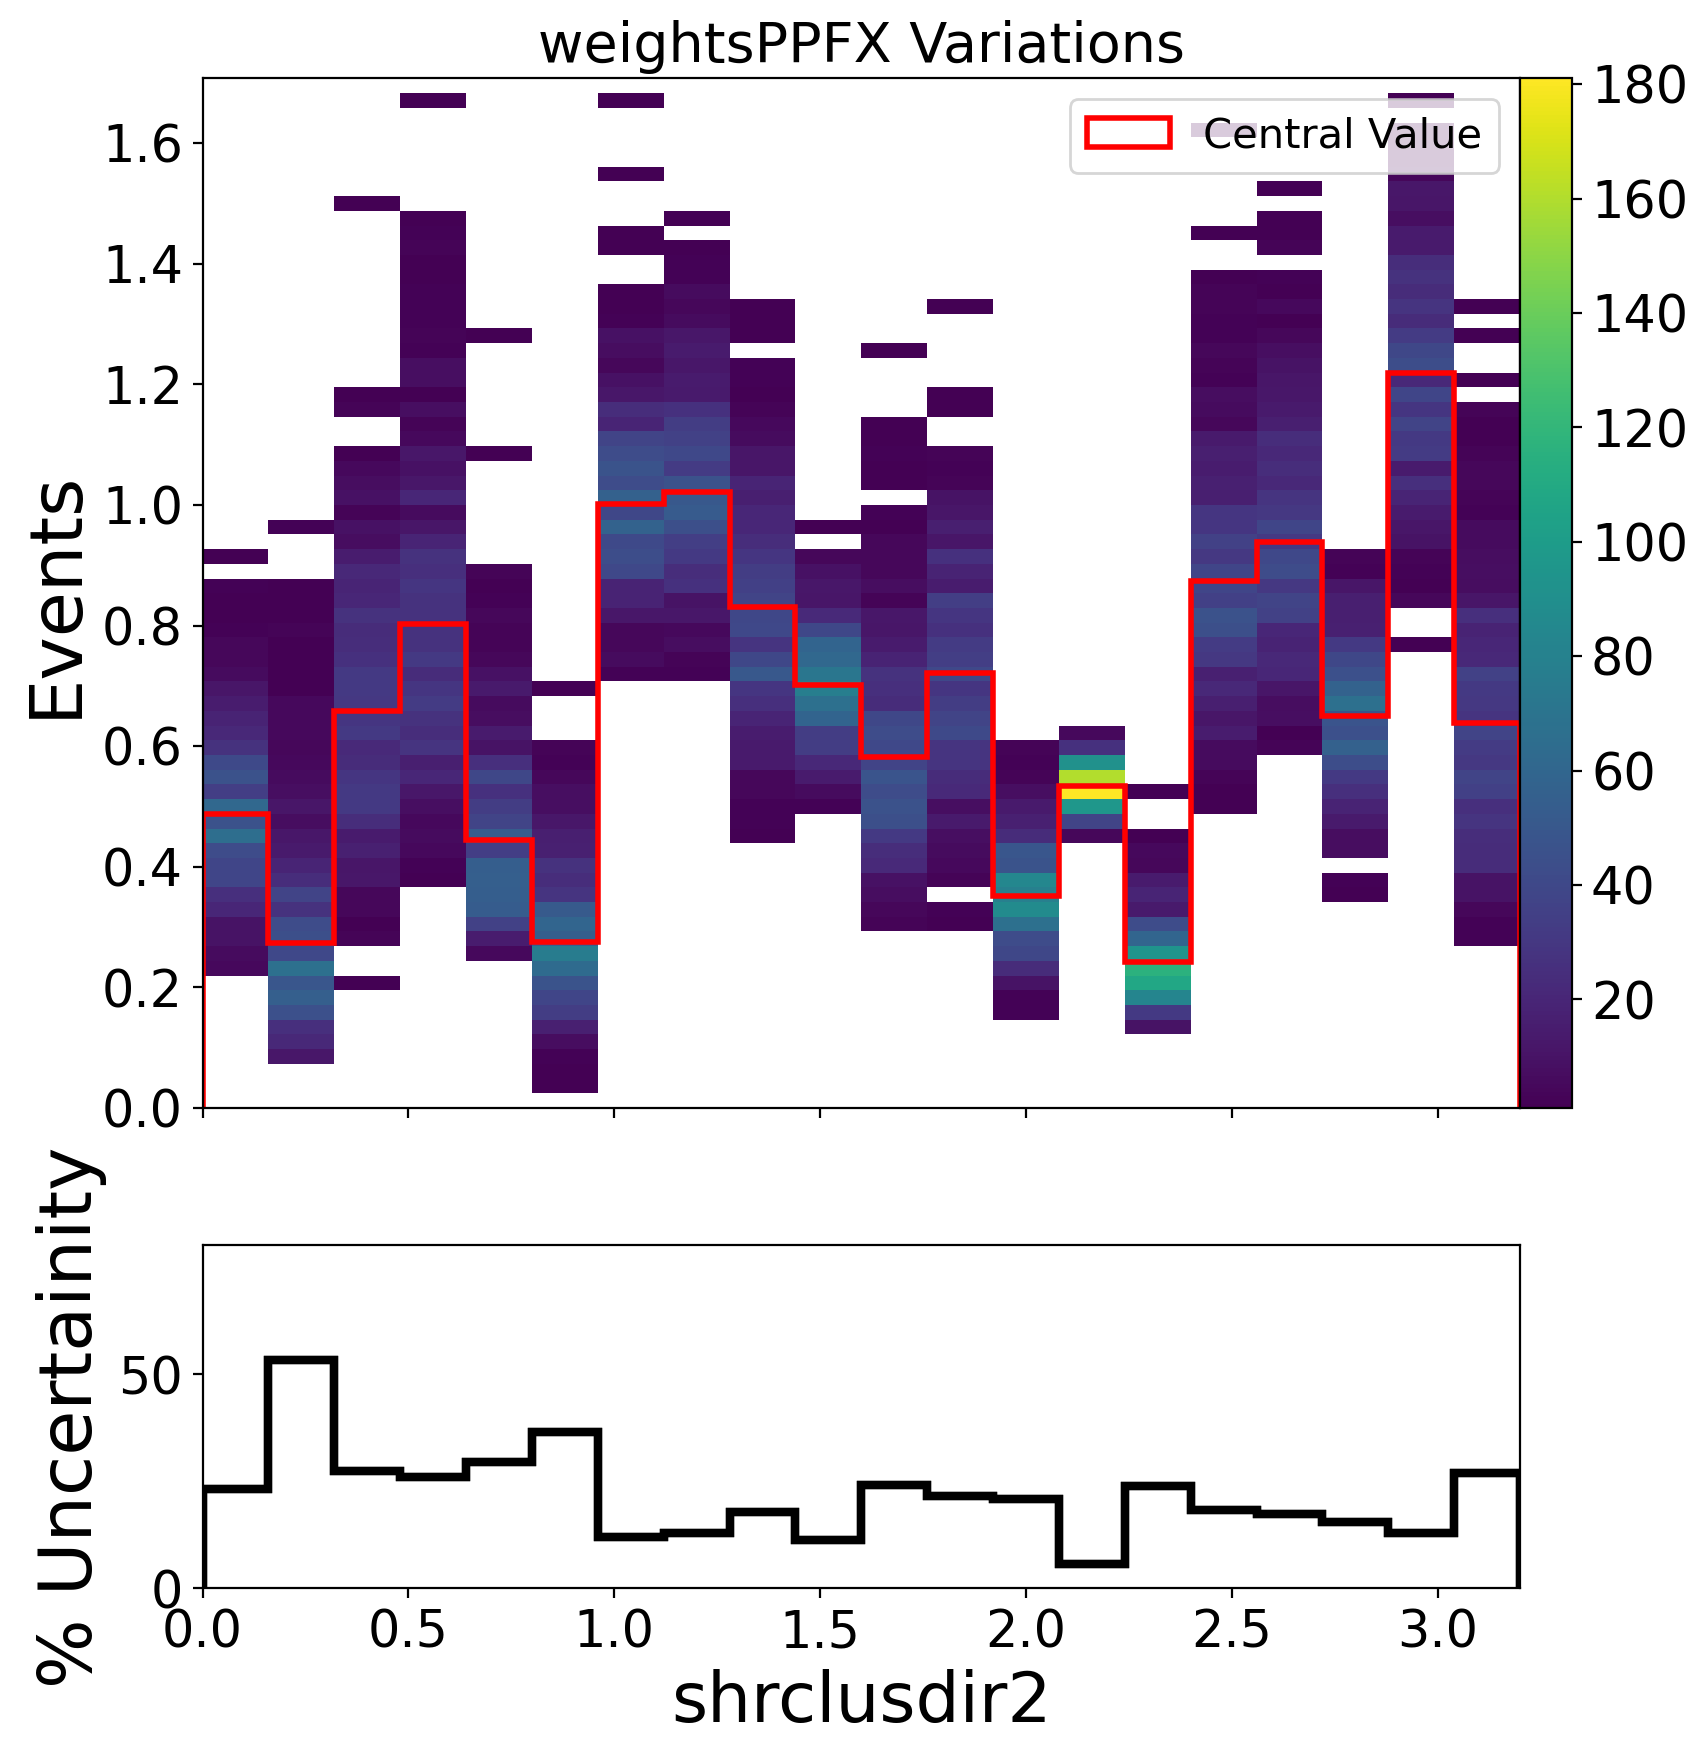

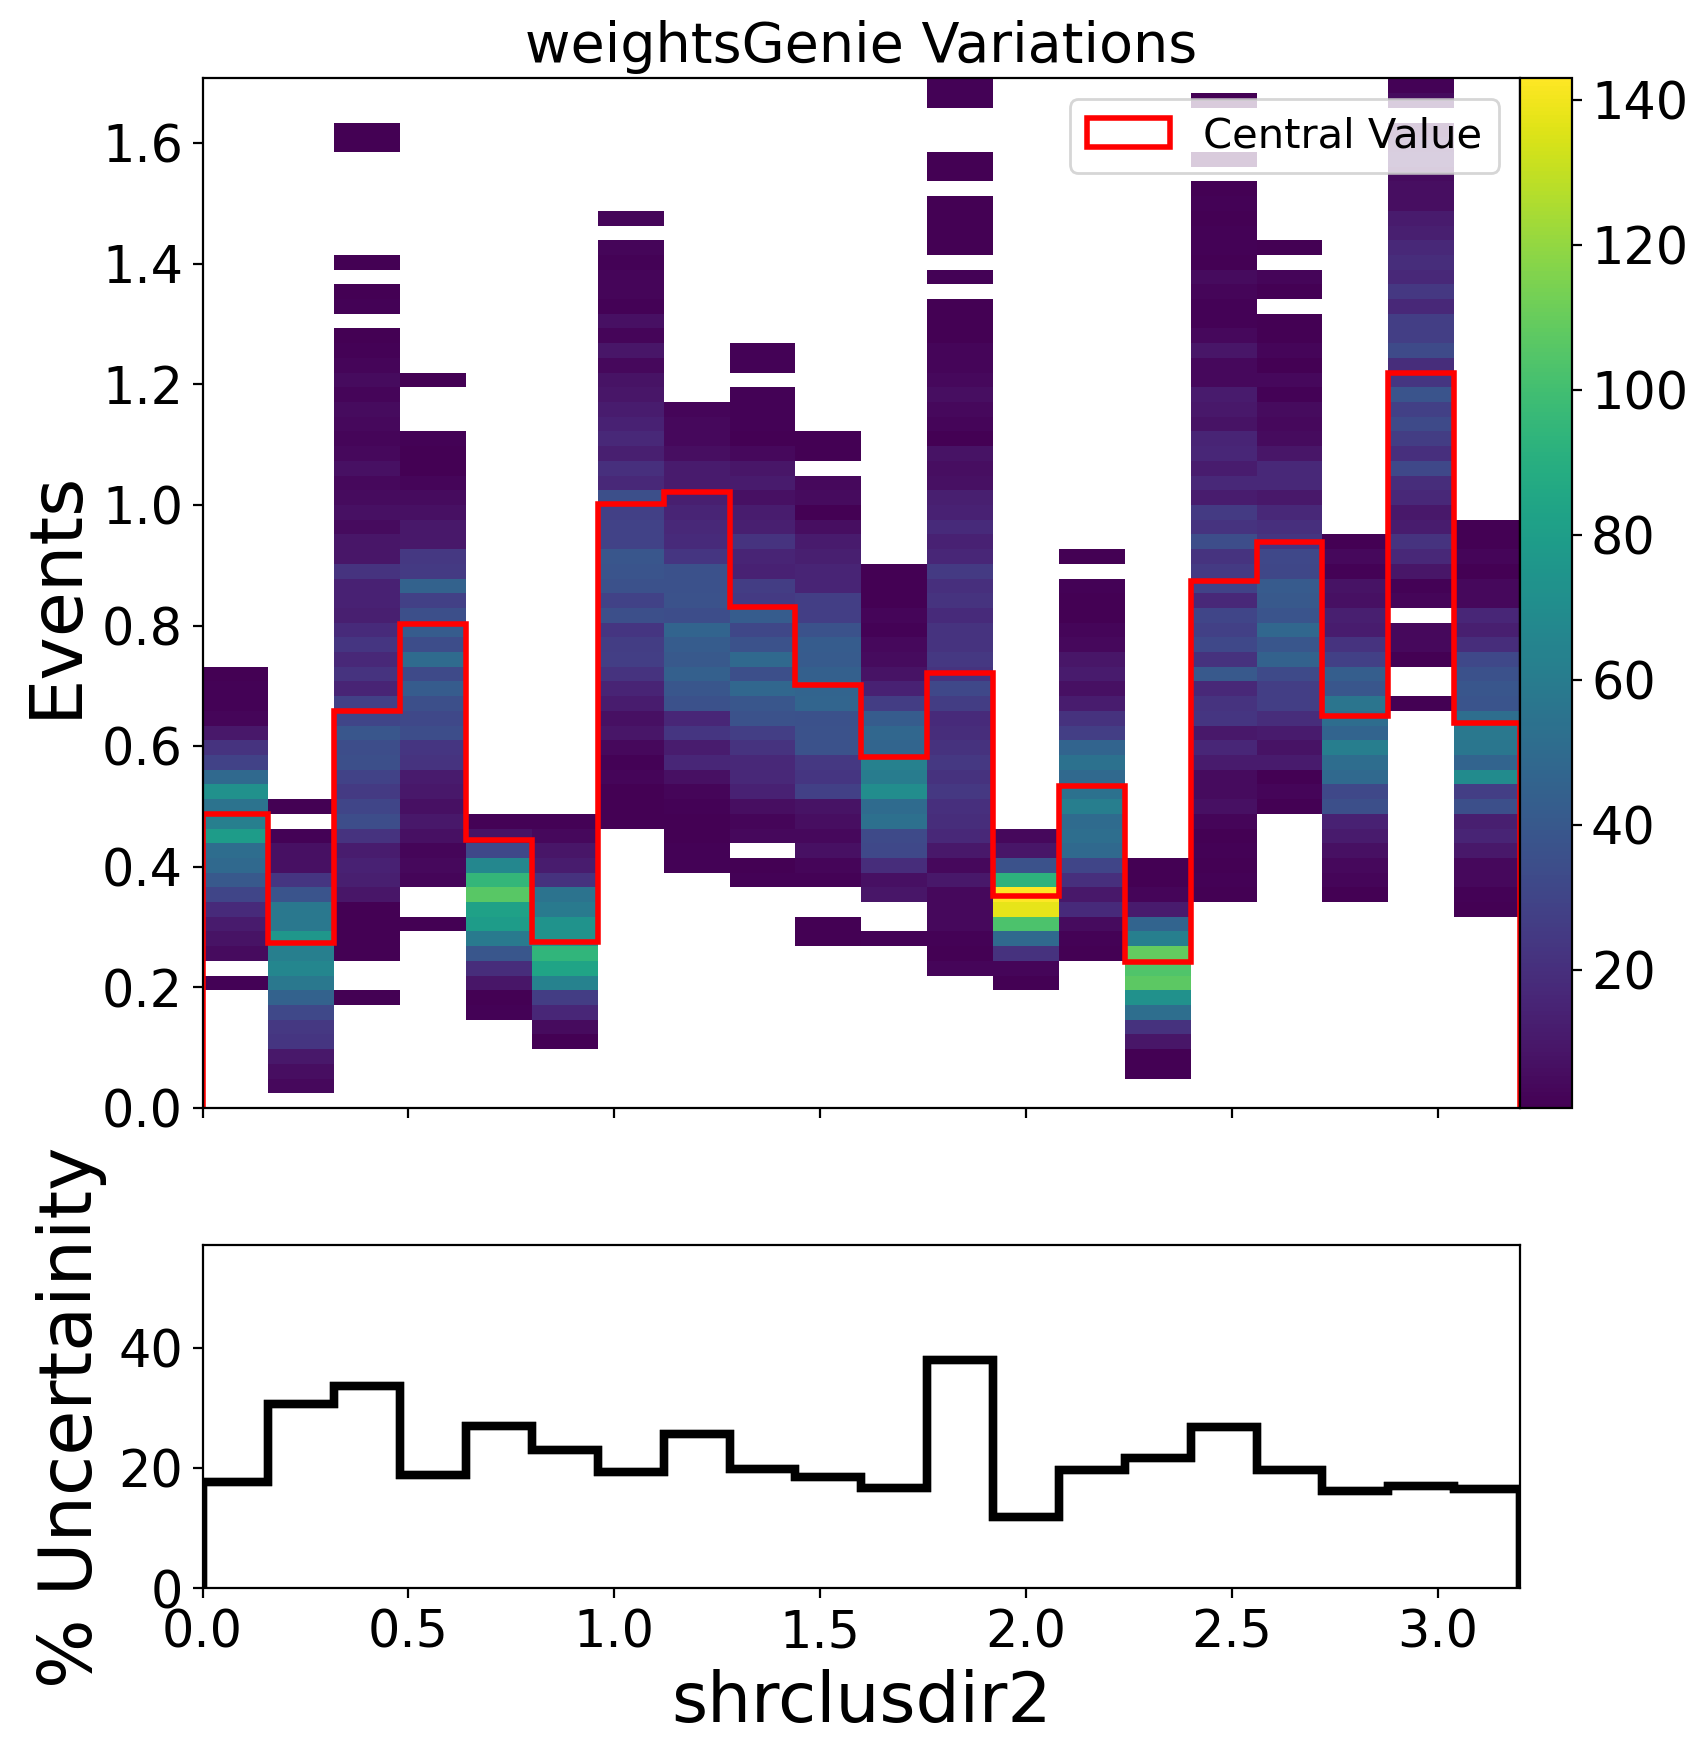

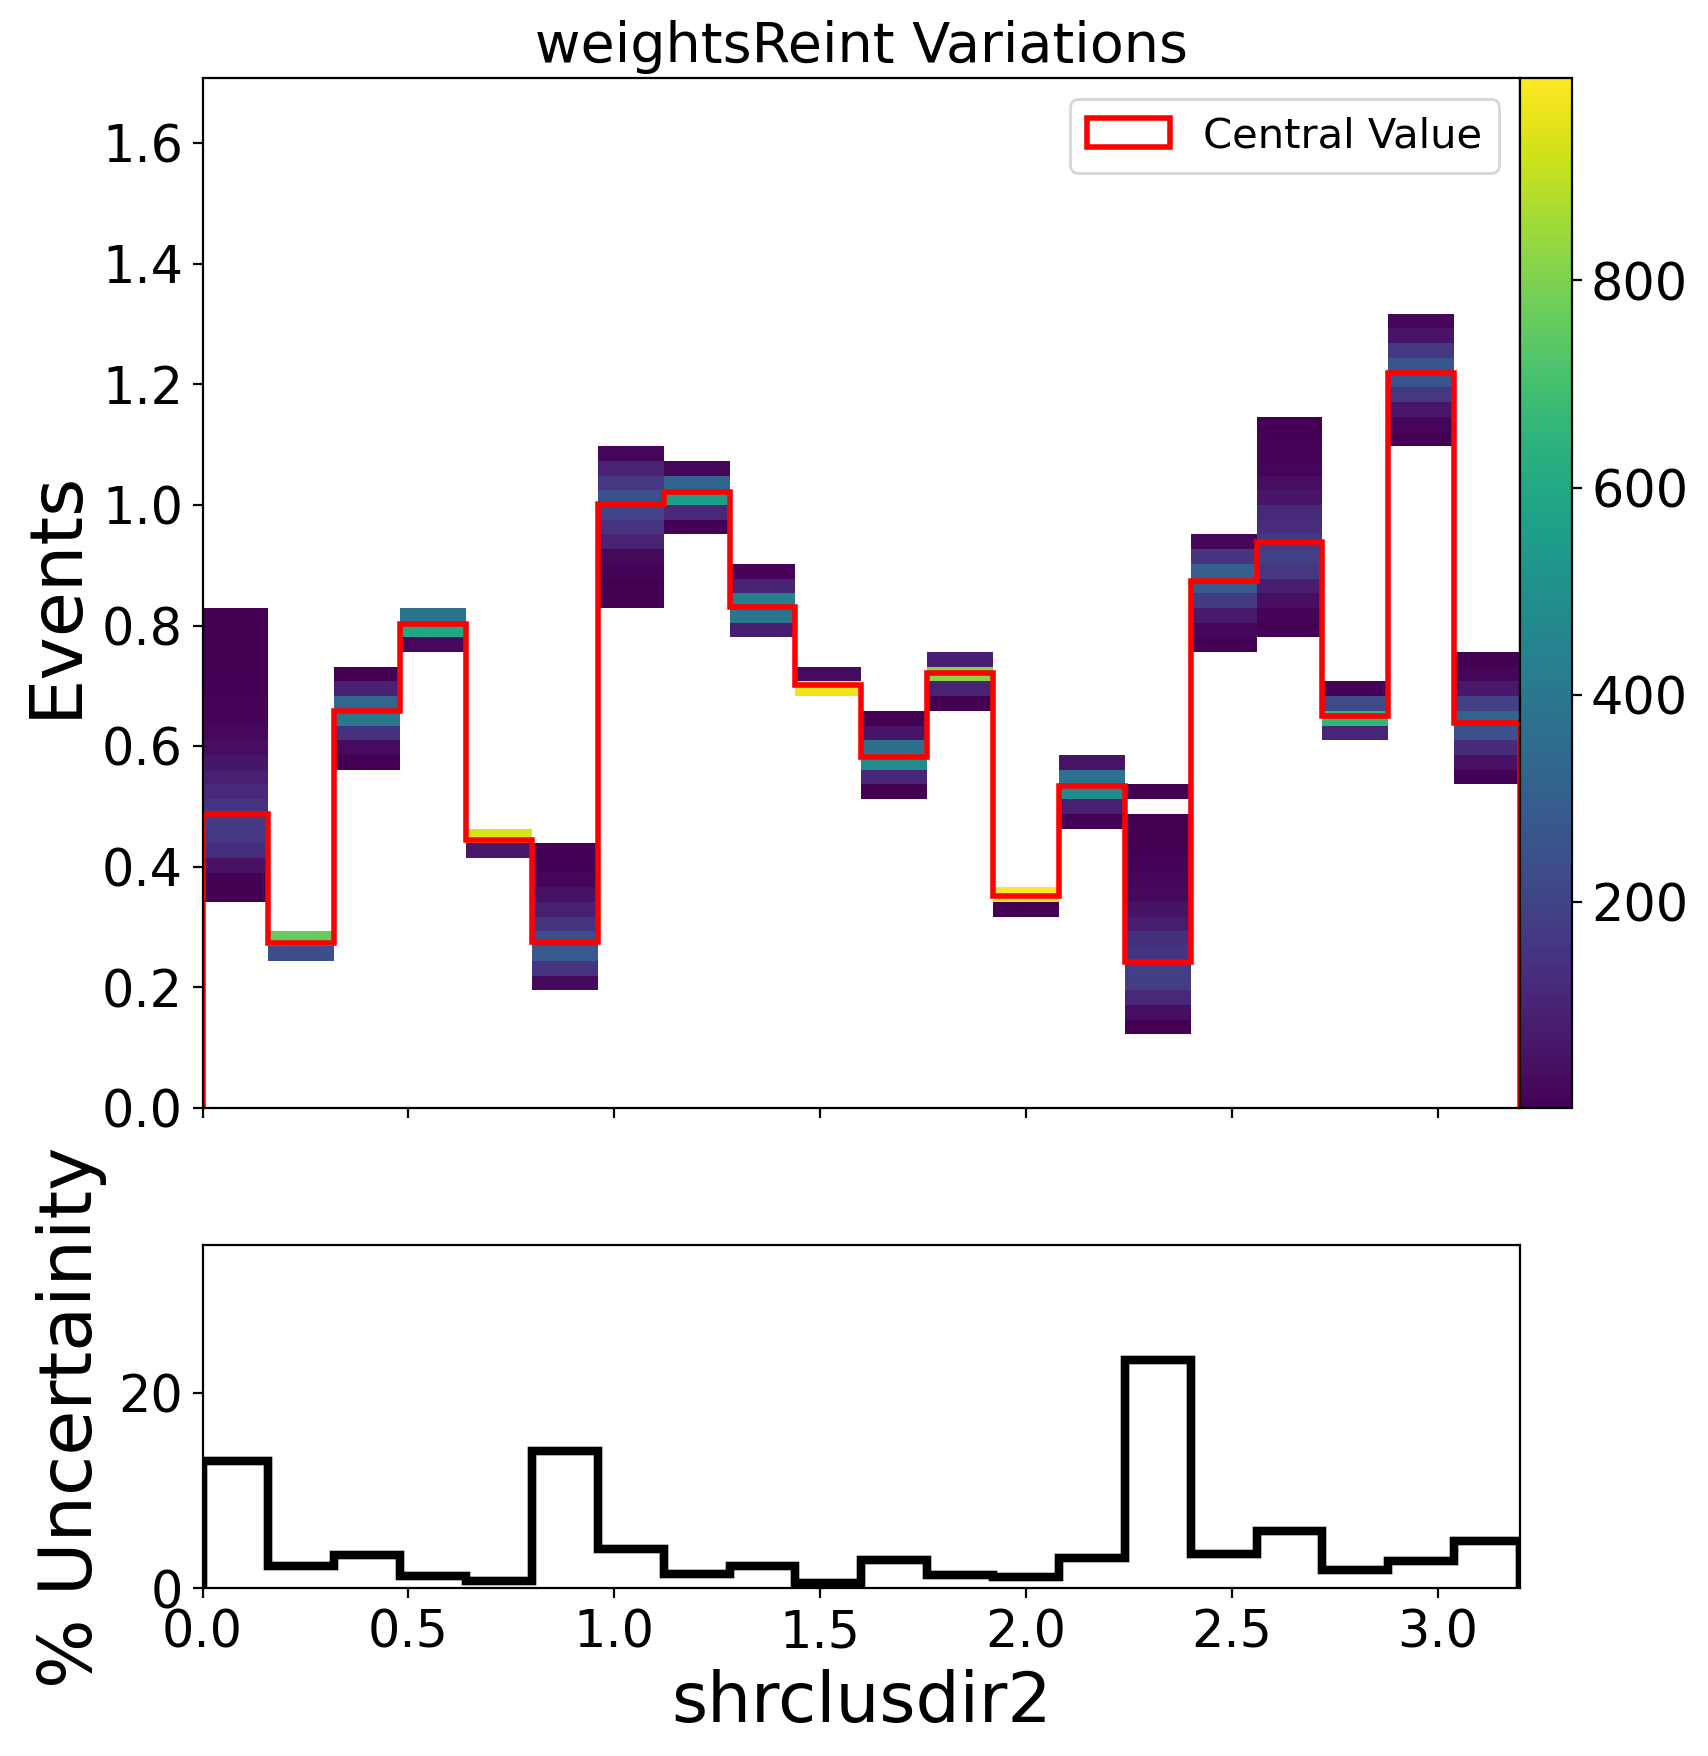

In [23]:
HNL_masses = Constants.HNL_mass_samples
for Variable in Variable_list:
    Plot_multisim(results_dict[Variable], Variable, savefig=False, display=True)

## Check fraction is flat across distribution

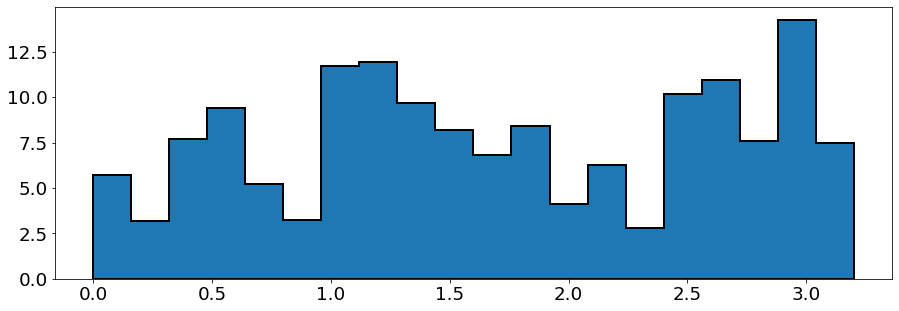

In [46]:
cov_ppfx = results_dict[Variable]["weightsPPFX"][0]
cov_genie = results_dict[Variable]["weightsGenie"][0]
# var_Overlay = samples_dict["overlay"][Variable]

varis=final_merged[Variable]
weights=[final_merged["weight"]]
labels=[fr"In-Cryo $\nu$"]
xlims = [bins_var[0],bins_var[-1]]

tot_ppfx_err=np.sqrt(np.diag(cov_ppfx))
tot_genie_err=np.sqrt(np.diag(cov_genie))

plot=plt.hist(varis,
          label=labels,
          range=xlims,bins=bins_dict[Variable],
          histtype="stepfilled",
          stacked=True,density=False,linewidth=2,edgecolor="black",
          weights=weights)

Text(0, 0.5, 'Fractional error')

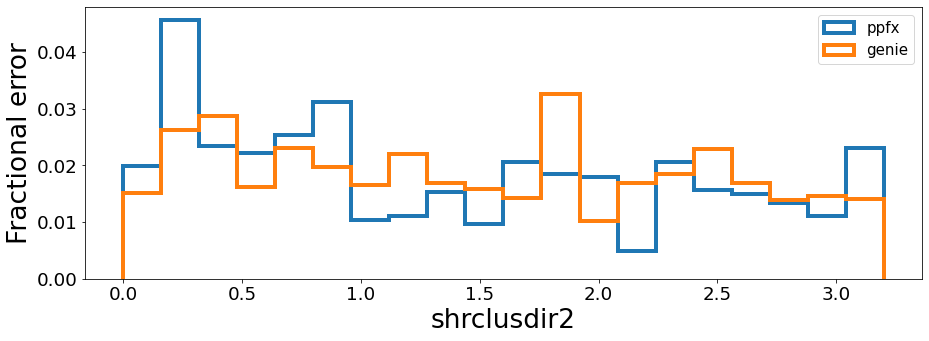

In [50]:
# frac = np.divide(tot_mcerr, plot[0])
frac_ppfx = np.divide(tot_ppfx_err, plot[0])
frac_genie = np.divide(tot_genie_err, plot[0])

bins_cent=(bins_dict[Variable][:-1]+bins_dict[Variable][1:])/2
plt.hist(bins_cent,weights=np.nan_to_num(frac_ppfx),bins=bins_dict[Variable],range=xlims,density=False, label="ppfx", histtype="step", lw=4)
plt.hist(bins_cent,weights=np.nan_to_num(frac_genie),bins=bins_dict[Variable],range=xlims,density=False, label="genie",  histtype="step", lw=4)
plt.legend()

plt.xlabel(Variable)
plt.ylabel(f"Fractional error")
# plt.savefig("plots/Data_MC_comparison/Overlay_sys_unc/" + Params["Run"] + f"_{variable}_ppfx_and_genie_frac_err.png")

In [54]:
#Calculate average
length = len(frac_ppfx)
# total = sum(np.nan_to_num(frac))
total_ppfx = sum(np.nan_to_num(frac_ppfx))
total_genie = sum(np.nan_to_num(frac_genie))

# mean = total/length
mean_ppfx = total_ppfx/length 
mean_genie = total_genie/length 

print(Run)

print(f"mean ppfx is {mean_ppfx}")
print(f"mean genie is {mean_genie}")

run1
mean ppfx is 0.01874336569193353
mean genie is 0.018778560778751965


## Save uncertainty in Constants file

## End of code